# Visual Question Answering by Deep Learning

## Several Resources
- [article](http://iamaaditya.github.io/2016/04/visual_question_answering_demo_notebook) and [jupyter notebook](https://github.com/iamaaditya/VQA_Demo/blob/master/Visual_Question_Answering_Demo_in_python_notebook.ipynb) and [github](https://github.com/iamaaditya/VQA_Demo) from Aaditya Prakash
- [article](https://avisingh599.github.io/deeplearning/visual-qa/) and [github](https://github.com/avisingh599/visual-qa) from Avi Singh
- [VQA website](http://visualqa.org/) with dataset download

## Idea
- Use CNN to convert images into vectors (e.g., by VGG16)
- Use word embedding to convert words into vectors, and use LSTM to convert sentences into vectors (several layers of LSTM can capture higher order sequence dependencies)
- Merge image vectors and text vectors, and use a deep MLP to learn their correlations - So far the output is a fixed set of word labels (so still not really an open-question-answering system yet...)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython import display

In [3]:
import keras
print keras.__version__

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.
1.0.5


Using gpu device 0: GeForce GTX 980M (CNMeM is disabled, cuDNN 5005)


In [4]:
import numpy as np

from keras import models, layers, optimizers, metrics
from keras.utils import visualize_util
from keras.preprocessing import sequence

from scipy.misc import imresize
from skimage.io import imread
from skimage.util import img_as_ubyte

## Image Vector Model
- VGG16 without the top 2 layers
- See [this notebook](keras-notes/IMAGE%20-%20CIFA%20with%20pretrained%20VGG.ipynb) for how to load pre-trained vgg
- previous versions of keras have problems with poping out layers, see [discussions](https://github.com/fchollet/keras/issues/2371#issuecomment-211734276) here and [update](https://github.com/fchollet/keras/pull/2418#issuecomment-231723852)

In [5]:
## code to pop last layer from model
## cited from https://github.com/fchollet/keras/issues/2640
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

In [159]:
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

def build_vgg16(weights_file = None):
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    if weights_file is not None:
        model.load_weights(weights_file)
    
    return model

image_model = build_vgg16("../data/vgg16_keras/vgg16_weights.h5")
print "original # of layers", len(image_model.layers), "output shape", image_model.output_shape
## pop out the last two layers
pop_layer(image_model)
pop_layer(image_model)
image_model.compile(loss = "mse", optimizer = "sgd")
print "after removing, # of layers", len(image_model.layers), "output_shape", image_model.output_shape

original # of layers 37 output shape (None, 1000)
after removing, # of layers 35 output_shape (None, 1000)


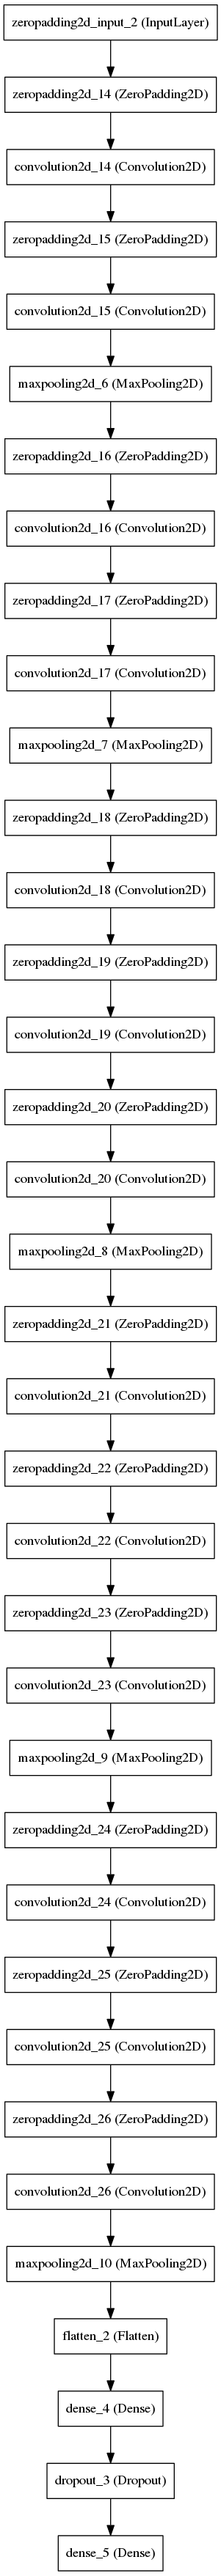

In [9]:
visualize_util.plot(image_model, to_file="../models/vgg16.png")
display.Image(filename = "../models/vgg16.png")

In [174]:
def img2vec(img):
    ## preprocessing
    img = imresize(img, (224, 224))
    img = img_as_ubyte(img).astype("float32")
    
    ## RGB to BGR
    img = img[:, :, ::-1]
    
    ## zero-centerized
#     img[:,:,0] -= 103.939
#     img[:,:,1] -= 116.779
#     img[:,:,2] -= 123.68

    ## theano format
    img = img.transpose((2, 0, 1))
    
    img_batch = np.expand_dims(img, axis = 0)
#     class_labels = open("../data/caffe_ilsvrc12/synset_words.txt").readlines()
#     print class_labels[image_model.predict_classes(img_batch)[0]]
    vec = image_model.predict(img_batch)
    return vec

(1, 4096)

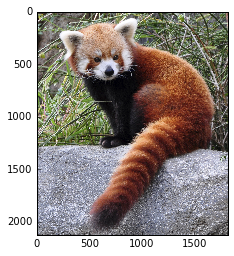

In [175]:
url = "http://www.beardsleyzoo.com/wp-content/uploads/2015/10/Red-Panda-Outside.jpg"
img = imread(url)
plt.imshow(img)
img_vec = img2vec(img)
img_vec.shape

## Word Vector Model
- use [spacy](https://spacy.io/) to load [glove](http://nlp.stanford.edu/projects/glove/) pretrained vectors
- install vector files in spacy
    - read [here](https://spacy.io/docs/tutorials/load-new-word-vectors) for how to load glove pretrained binary vectors via spacy
    - use [sputnik](https://github.com/spacy-io/sputnik), you need the latest spacy version for this to work, see [discussion](https://github.com/spacy-io/spaCy/issues/338) for spacy 0.101
    ```
    sputnik —name spacy install en
    sputnik --name spacy install en_glove_cc_300_1m_vectors
    ```
- alternatives include [skip-thoughts](https://github.com/ryankiros/skip-thoughts), [further reading](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/)

In [176]:
from spacy.en import English
nlp = English()
## it is actually the same weights used by default
#nlp.vocab.load_vectors("/home/dola/workspace/data/glove/glove.6B.300d.txt.bz2")
nlp.vocab.load_vectors("../data/en_glove_cc_300_1m_vectors.bin")

0

In [177]:
vking = nlp.vocab[u"king"].vector
vman = nlp.vocab[u"man"].vector
vwoman = nlp.vocab[u"woman"].vector

vqueen_estimate = vking - vman + vwoman
vqueen = nlp.vocab[u"queen"].vector

from scipy.spatial.distance import cosine
print "cosine similarity", 1-cosine(vqueen_estimate, vqueen)
print "as comparison", 1-cosine(nlp.vocab[u"earth"].vector, nlp.vocab[u"moon"].vector)

cosine similarity 0.618189307792
as comparison 0.580242097378


In [178]:
import re
def txt2vec(text):
    """return a sequence of embedding vectors as the representation of text
    It won't be able to be used directly with image vectors, but LSTM will
    further reduce it to a single vector - will be discussed below
    """
    text = unicode(text)
    wordpat = re.compile(r"\w+")
    ## need to pad the sequence to 30 tokens long for VQA model
    vecs = np.zeros((30, 300), dtype = "float32") 
    for i, w in enumerate(wordpat.findall(text)):
        vecs[i, :] = nlp.vocab[w].vector
    return np.expand_dims(vecs, axis = 0)

In [179]:
txt_vec = txt2vec(u"What color is the roof?")
txt_vec.shape

(1, 30, 300)

## Putting Image and Word Vectors Together
- Use the pretrained model provided [here](https://github.com/iamaaditya/VQA_Demo)

In [180]:
from keras.layers import Reshape, LSTM, Merge, Dense, Activation, Dropout
from keras.models import Sequential
def VQA_MODEL():
    image_feature_size          = 4096
    word_feature_size           = 300
    number_of_LSTM              = 3
    number_of_hidden_units_LSTM = 512
    max_length_questions        = 30
    number_of_dense_layers      = 3
    number_of_hidden_units      = 1024
    activation_function         = 'tanh'
    dropout_pct                 = 0.5


    # Image model
    model_image = Sequential()
    model_image.add(Reshape((image_feature_size,), input_shape=(image_feature_size,)))

    # Language Model
    model_language = Sequential()
    model_language.add(LSTM(number_of_hidden_units_LSTM, return_sequences=True, input_shape=(max_length_questions, word_feature_size)))
    model_language.add(LSTM(number_of_hidden_units_LSTM, return_sequences=True))
    model_language.add(LSTM(number_of_hidden_units_LSTM, return_sequences=False))

    # combined model
    model = Sequential()
    model.add(Merge([model_language, model_image], mode='concat', concat_axis=1))

    for _ in xrange(number_of_dense_layers):
        model.add(Dense(number_of_hidden_units, init='uniform'))
        model.add(Activation(activation_function))
        model.add(Dropout(dropout_pct))

    model.add(Dense(1000))
    model.add(Activation('softmax'))

    return model

In [181]:
#vqa_model = models.model_from_json(open("../data/vqa-demo/VQA_MODEL.json").read())
vqa_model = VQA_MODEL()
vqa_model.load_weights("../data/vqa-demo/VQA_MODEL_WEIGHTS.hdf5")
vqa_model.compile(loss = "categorical_crossentropy", 
                  optimizer = "rmsprop", 
                  metrics=["accuracy"])

In [182]:
from sklearn.externals import joblib
label_encoder = joblib.load("../data/vqa-demo/FULL_labelencoder_trainval.pkl")

In [183]:
label_encoder.inverse_transform(np.arange(100, 110))

array([u'bathing', u'bathroom', u'batter', u'batting', u'beach', u'beagle',
       u'bear', u'beard', u'bears', u'bed'], 
      dtype='<U18')

know a little bit more about vqa

In [184]:
print vqa_model.input_shape
print vqa_model.output_shape
# visualize_util.plot(vqa_model, to_file="../models/vqa.png")
# display.Image("../models/vqa.png")
vqa_model.summary()

[(None, 30, 300), (None, 4096)]
(None, 1000)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_13 (LSTM)                   (None, 30, 512)       1665024                                      
____________________________________________________________________________________________________
lstm_14 (LSTM)                   (None, 30, 512)       2099200                                      
____________________________________________________________________________________________________
lstm_15 (LSTM)                   (None, 512)           2099200                                      
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 4096)          0                                            
______________________________________________

In [185]:
y = vqa_model.predict([txt_vec, img_vec])
top_labels_index = y.argsort(axis=1)[:,-5:][:, ::-1]
label_encoder.inverse_transform(top_labels_index)

array([[u'yes', u'no', u'all', u'front', u"i don't know"]], 
      dtype='<U18')

In [186]:
## putting together
def vqa(image_url, question):
    txt_vector = txt2vec(question)
    img_vector = img2vec(imread(image_url))
    scores = vqa_model.predict([txt_vector, img_vector])
    top5 = scores.argsort(axis = 1)[:, -5:][:, ::-1]
    top5_labels = label_encoder.inverse_transform(top5).ravel()
    top5_probs = scores[:, top5].ravel()
    answer = " ".join(["%s(%.2f)" % (label, prob) for label, prob in zip(top5_labels, top5_probs)])
    plt.imshow(imread(image_url))
    plt.title("%s \n answers: %s" % (question, answer))
    #return txt_vector, img_vector
    return scores
    return top5_labels, top5_probs

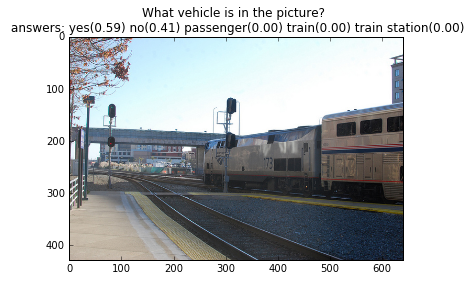

In [193]:
image_url = "https://raw.githubusercontent.com/iamaaditya/VQA_Demo/master/test.jpg"
#image_url = "http://www.newarkhistory.com/indparksoccerkids.jpg"
#image_url = "http://www.beardsleyzoo.com/wp-content/uploads/2015/10/Red-Panda-Outside.jpg"
#question = u"what sport is this"
#question = u"what is the vehicle in the picture?"
question = "What vehicle is in the picture?"
scores = vqa(image_url, question)